In [1]:
from medmnist import PneumoniaMNIST
from medmnist import INFO

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl
from pennylane.qnn import TorchLayer

In [2]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [3]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [4]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [5]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [7]:
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.5)

In [8]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_loader)

In [9]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


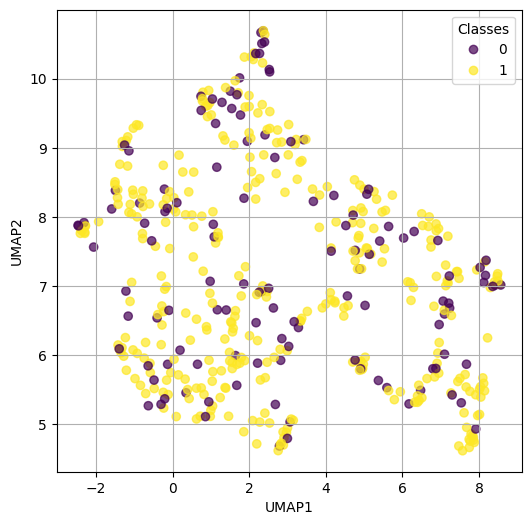

In [10]:
y_train = torch.cat([y for _, y in train_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


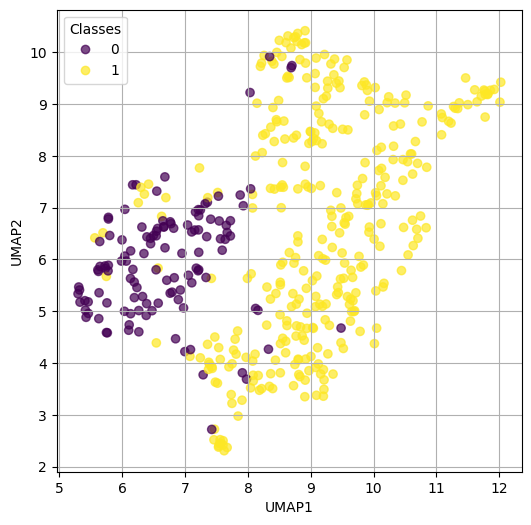

In [11]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

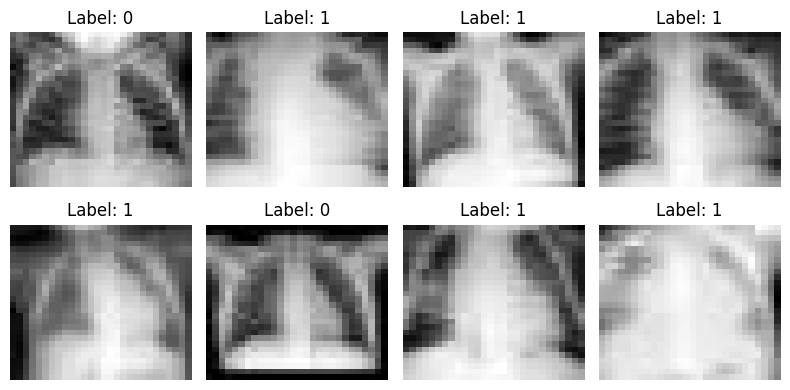

In [12]:
#original images
x_batch, y_batch = sample_batch(train_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_248557/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


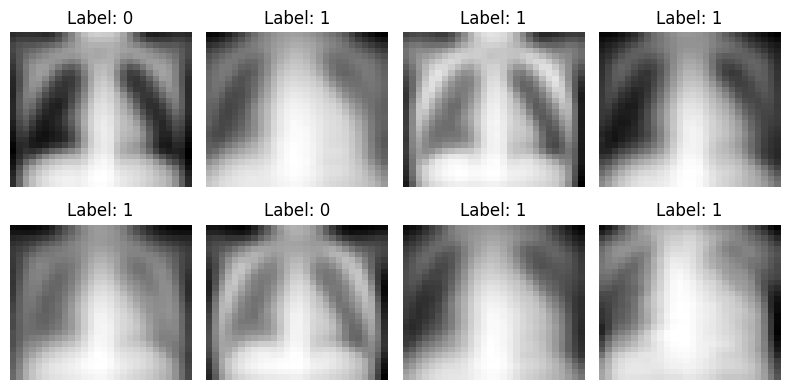

In [13]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

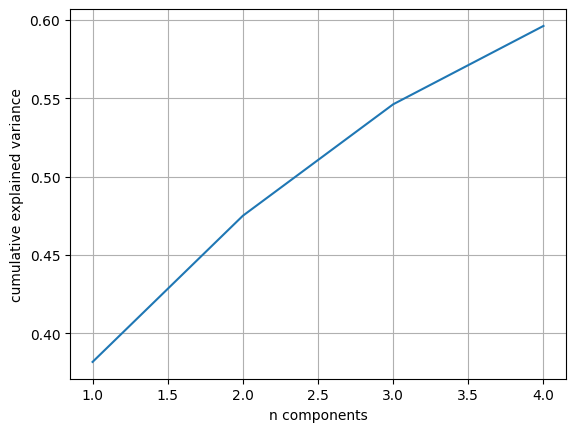

In [14]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

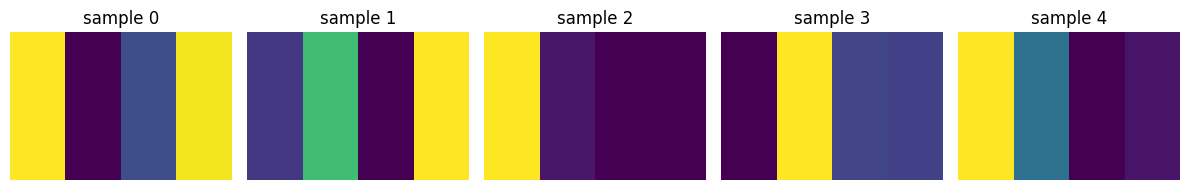

In [50]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [17]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


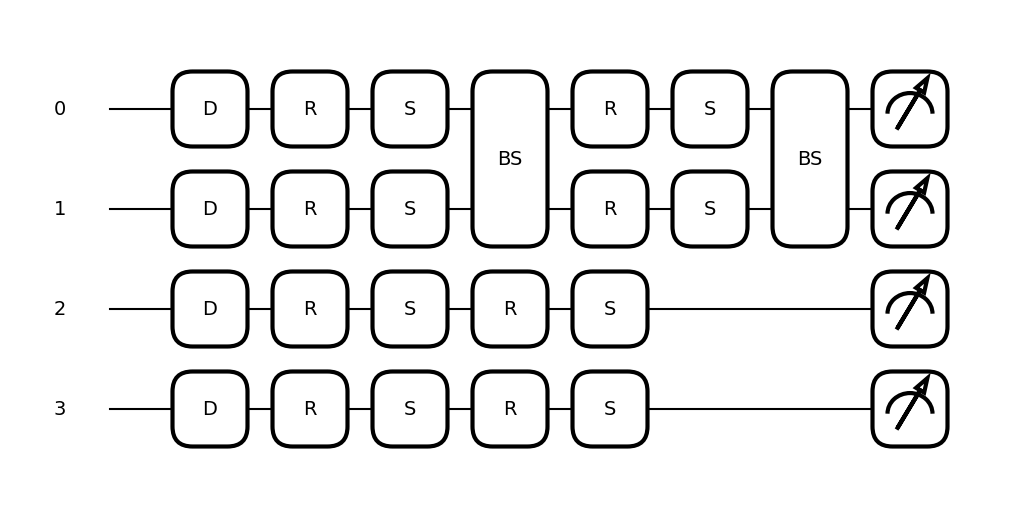

In [18]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)
x_test_scaled = scaler.fit_transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [20]:
print(x_train_tensor[0])

tensor([ 0.2815, -0.0275,  0.1115,  0.6767])


In [21]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [22]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [23]:
print(output)

tensor([-0.0364, -0.1395, -0.0491, -0.0102], dtype=torch.float64)


In [24]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [26]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.head(x)

In [27]:
# def train_v2(model, dataloader, optimizer, loss_fn, device, results_path, model_path):
def train_v2(model, dataloader, optimizer, loss_fn, device):

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    model.train()

    total_loss = 0
    total_samples = 0
    correct = 0
    all_labels = []
    all_preds = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}",
        })

        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics

In [28]:
# def train(model, dataloader, optimizer, loss_fn, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     for x_batch, y_batch in progress_bar:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         # print(x_batch.shape)
#         optimizer.zero_grad()
#         logits = model(x_batch)
#         y_batch = y_batch.view(-1).long()
#         # print(logits.shape)
#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x_batch.size(0)
#         pred = logits.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()
#         total_samples += x_batch.size(0)

#         progress_bar.set_postfix({
#             "loss": f"{loss.item():.4f}",
#             "acc": f"{(correct/total_samples):.4f}"
#         })

#     avg_loss = total_loss / total_samples
#     avg_acc = correct / total_samples
#     return avg_loss, avg_acc

In [29]:
def evaluate_v2(model, dataloader, loss_fn, device):
    model.eval()

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    all_probs = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = recall_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics, all_preds, all_probs, all_labels
    

In [30]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     with torch.no_grad():
#         for x_batch, y_batch in progress_bar:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(x_batch)
#             y_batch = y_batch.view(-1).long()
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)
#             pred = outputs.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()
#             total_samples += x_batch.size(0)

#             progress_bar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total_samples):.4f}"
#             })

#         avg_loss = total_loss / total_samples
#         avg_acc = correct / total_samples
#         return avg_loss, avg_acc

In [31]:
epochs = 10
device = "cpu"
cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumWrapper                           --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 146
Trainable params: 146
Non-trainable params: 0

In [32]:
train_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

val_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

best_val_f1 = 0

for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    # train_loss, train_acc = train(cv_model, train_loader, optimizer, criterion, device)
    train_loss, train_acc, train_prec, train_rec, train_f1, train_report = train_v2(cv_model, train_loader, optimizer, criterion, device)
    # val_loss, val_acc = evaluate(cv_model, val_loader, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_report, val_preds, val_probs, val_labels = evaluate_v2(cv_model, val_loader, criterion, device)

    train_metrics["acc"].append(train_acc)
    train_metrics["loss"].append(train_loss)
    train_metrics["rec"].append(train_rec)
    train_metrics["prec"].append(train_prec)
    train_metrics["f1"].append(train_f1)
    
    val_metrics["acc"].append(val_acc)
    val_metrics["loss"].append(val_loss)
    val_metrics["rec"].append(val_rec)
    val_metrics["prec"].append(val_prec)
    val_metrics["f1"].append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(cv_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth")
    
    # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
    # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

    tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
    tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

import json
with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_train_metrics.json", "w") as f:
    json.dump(train_metrics, f, indent=4)

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_val_metrics.json", "w") as f:
    json.dump(val_metrics, f, indent=4)

epoch 1/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.41it/s, loss=0.9153, acc=0.7366]


Train loss: 1.3980 | Train acc: 0.7021 | Train rec: 0.7021 | Train prec: 0.5543 | Train f1: 0.6142
Val loss: 0.9153 | Val acc: 0.7366 | Val rec: 0.7366 | Val prec: 0.6250 | Val f1: 0.7366
epoch 2/10


Training: 100%|████████| 17/17 [00:01<00:00, 10.71it/s, loss=0.3673, acc=0.8130]


Train loss: 0.5792 | Train acc: 0.7191 | Train rec: 0.7191 | Train prec: 0.5827 | Train f1: 0.6265
Val loss: 0.3673 | Val acc: 0.8130 | Val rec: 0.8130 | Val prec: 0.8367 | Val f1: 0.8130
epoch 3/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.31it/s, loss=0.3346, acc=0.8378]


Train loss: 0.3099 | Train acc: 0.8596 | Train rec: 0.8596 | Train prec: 0.8791 | Train f1: 0.8646
Val loss: 0.3346 | Val acc: 0.8378 | Val rec: 0.8378 | Val prec: 0.8717 | Val f1: 0.8378
epoch 4/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.54it/s, loss=0.3373, acc=0.8397]


Train loss: 0.3083 | Train acc: 0.8596 | Train rec: 0.8596 | Train prec: 0.8791 | Train f1: 0.8646
Val loss: 0.3373 | Val acc: 0.8397 | Val rec: 0.8397 | Val prec: 0.8727 | Val f1: 0.8397
epoch 5/10


Training: 100%|████████| 17/17 [00:01<00:00, 10.70it/s, loss=0.3324, acc=0.8416]


Train loss: 0.3052 | Train acc: 0.8617 | Train rec: 0.8617 | Train prec: 0.8803 | Train f1: 0.8665
Val loss: 0.3324 | Val acc: 0.8416 | Val rec: 0.8416 | Val prec: 0.8737 | Val f1: 0.8416
epoch 6/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.39it/s, loss=0.3270, acc=0.8435]


Train loss: 0.3003 | Train acc: 0.8681 | Train rec: 0.8681 | Train prec: 0.8842 | Train f1: 0.8723
Val loss: 0.3270 | Val acc: 0.8435 | Val rec: 0.8435 | Val prec: 0.8746 | Val f1: 0.8435
epoch 7/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.49it/s, loss=0.3257, acc=0.8473]


Train loss: 0.2984 | Train acc: 0.8681 | Train rec: 0.8681 | Train prec: 0.8842 | Train f1: 0.8723
Val loss: 0.3257 | Val acc: 0.8473 | Val rec: 0.8473 | Val prec: 0.8766 | Val f1: 0.8473
epoch 8/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.45it/s, loss=0.3226, acc=0.8492]


Train loss: 0.2961 | Train acc: 0.8702 | Train rec: 0.8702 | Train prec: 0.8855 | Train f1: 0.8743
Val loss: 0.3226 | Val acc: 0.8492 | Val rec: 0.8492 | Val prec: 0.8776 | Val f1: 0.8492
epoch 9/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.45it/s, loss=0.3199, acc=0.8492]


Train loss: 0.2939 | Train acc: 0.8745 | Train rec: 0.8745 | Train prec: 0.8882 | Train f1: 0.8782
Val loss: 0.3199 | Val acc: 0.8492 | Val rec: 0.8492 | Val prec: 0.8776 | Val f1: 0.8492
epoch 10/10


Training: 100%|████████| 17/17 [00:01<00:00,  9.34it/s, loss=0.3183, acc=0.8511]

Train loss: 0.2910 | Train acc: 0.8745 | Train rec: 0.8745 | Train prec: 0.8882 | Train f1: 0.8782
Val loss: 0.3183 | Val acc: 0.8511 | Val rec: 0.8511 | Val prec: 0.8787 | Val f1: 0.8511


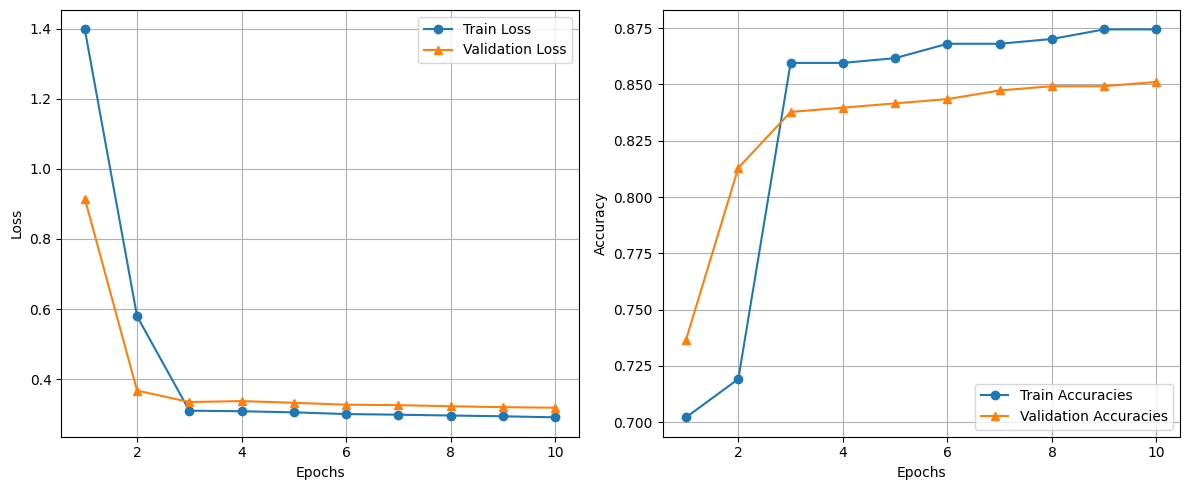

In [33]:
epochs = range(1, len(train_metrics["acc"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)    

plt.tight_layout()
plt.show()

In [35]:
device = "cpu"
test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████| 20/20 [00:02<00:00,  9.51it/s, loss=0.6152, acc=0.6362]

Test loss: 0.6152 | Test acc: 0.6362 | Test rec: 0.6362 | Test prec: 0.7907 | Test f1: 0.6362


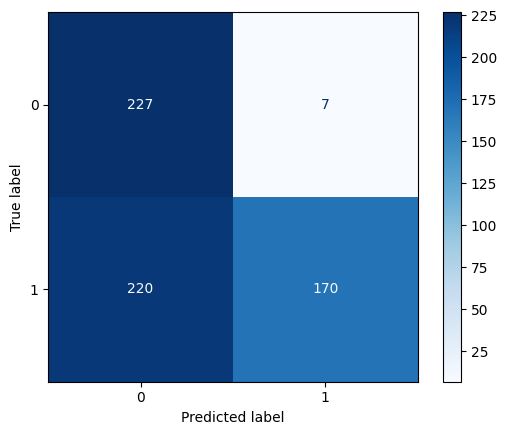

In [37]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.8883629191321498


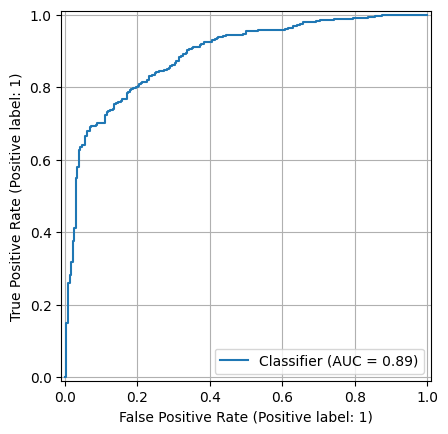

In [38]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

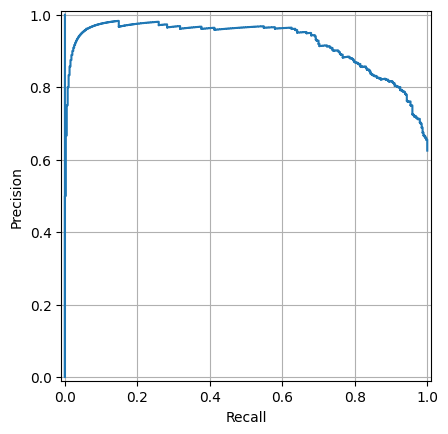

In [39]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()

## CLASSICAL MODEL

In [40]:
epochs = 10
# epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 114
Trainable params: 114
Non-trainable params: 0

In [41]:
c_train_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}
c_val_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

best_val_f1 = 0

for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    # train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
    train_loss, train_acc, train_prec, train_rec, train_f1, c_train_report = train_v2(classical_model, train_loader, optimizer, criterion, device)
    # val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, c_val_report, val_preds, val_probs, val_labels = evaluate_v2(classical_model, val_loader, criterion, device)

    c_train_metrics["acc"].append(train_acc)
    c_train_metrics["loss"].append(train_loss)
    c_train_metrics["rec"].append(train_rec)
    c_train_metrics["prec"].append(train_prec)
    c_train_metrics["f1"].append(train_f1)
        
    c_val_metrics["acc"].append(val_acc)
    c_val_metrics["loss"].append(val_loss)
    c_val_metrics["rec"].append(val_rec)
    c_val_metrics["prec"].append(val_prec)
    c_val_metrics["f1"].append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(classical_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth")


    # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
    # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


    tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
    tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_train_metrics.json", "w") as f:
    json.dump(c_train_metrics, f, indent=4)

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_val_metrics.json", "w") as f:
    json.dump(c_val_metrics, f, indent=4)
    
    # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
    # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

epoch 1/10


Training: 100%|███████| 17/17 [00:00<00:00, 290.41it/s, loss=0.6205, acc=0.7424]


Train loss: 0.6299 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.6205 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 2/10


Training: 100%|███████| 17/17 [00:00<00:00, 260.64it/s, loss=0.6039, acc=0.7424]


Train loss: 0.6103 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.6039 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 3/10


Training: 100%|███████| 17/17 [00:00<00:00, 328.59it/s, loss=0.5876, acc=0.7424]


Train loss: 0.5926 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5876 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 4/10


Training: 100%|███████| 17/17 [00:00<00:00, 300.18it/s, loss=0.5719, acc=0.7424]


Train loss: 0.5755 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5719 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 5/10


Training: 100%|███████| 17/17 [00:00<00:00, 293.41it/s, loss=0.5570, acc=0.7424]


Train loss: 0.5586 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5570 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 6/10


Training: 100%|███████| 17/17 [00:00<00:00, 334.17it/s, loss=0.5419, acc=0.7424]


Train loss: 0.5422 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5419 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 7/10


Training: 100%|███████| 17/17 [00:00<00:00, 306.72it/s, loss=0.5262, acc=0.7424]


Train loss: 0.5258 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5262 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 8/10


Training: 100%|███████| 17/17 [00:00<00:00, 250.98it/s, loss=0.5103, acc=0.7424]


Train loss: 0.5085 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.5103 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 9/10


Training: 100%|███████| 17/17 [00:00<00:00, 298.56it/s, loss=0.4932, acc=0.7424]


Train loss: 0.4911 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.4932 | Val acc: 0.7424 | Val rec: 0.7424 | Val prec: 0.5511 | Val f1: 0.7424
epoch 10/10


Training: 100%|███████| 17/17 [00:00<00:00, 327.51it/s, loss=0.4759, acc=0.7462]


Train loss: 0.4728 | Train acc: 0.7404 | Train rec: 0.7404 | Train prec: 0.5482 | Train f1: 0.6300
Val loss: 0.4759 | Val acc: 0.7462 | Val rec: 0.7462 | Val prec: 0.8109 | Val f1: 0.7462


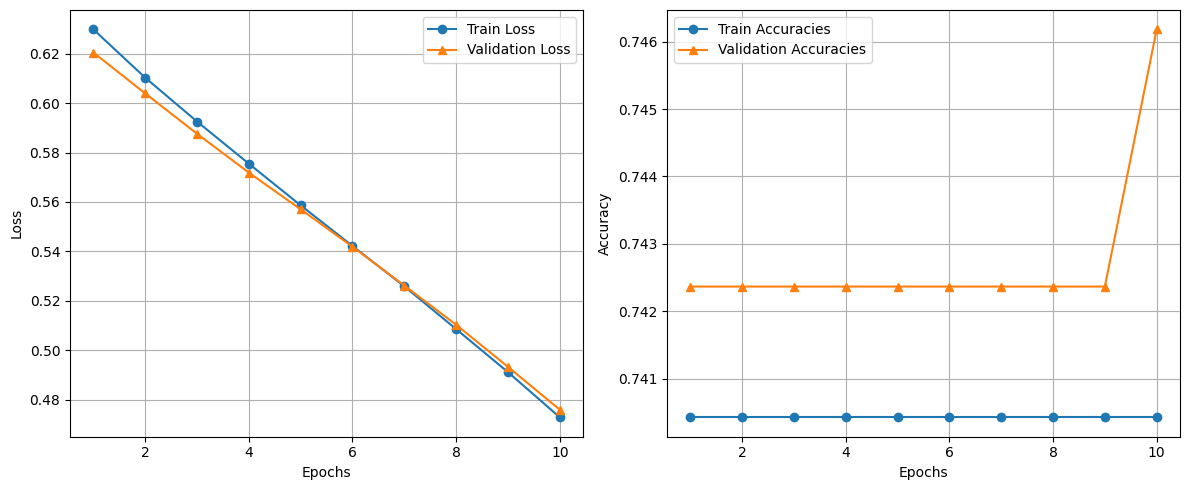

In [42]:
epochs = range(1, len(c_train_metrics["acc"]) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)    

plt.tight_layout()
plt.show()

In [44]:
test_classical_model = ClassicalModel()
test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training: 100%|███████| 20/20 [00:00<00:00, 313.03it/s, loss=0.6069, acc=0.6250]

Test loss: 0.6069 | Test acc: 0.6250 | Test rec: 0.6250 | Test prec: 0.3906 | Test f1: 0.6250


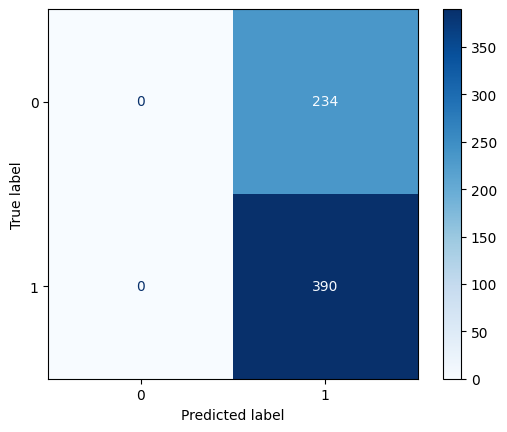

In [48]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.8375849222003069


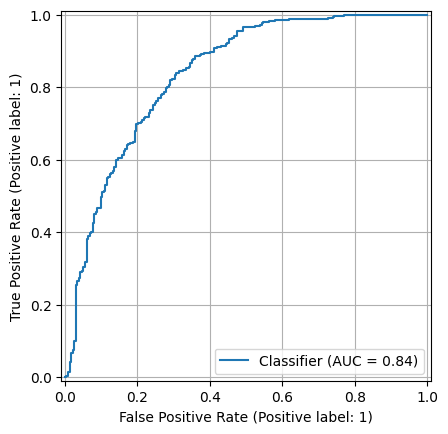

In [46]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

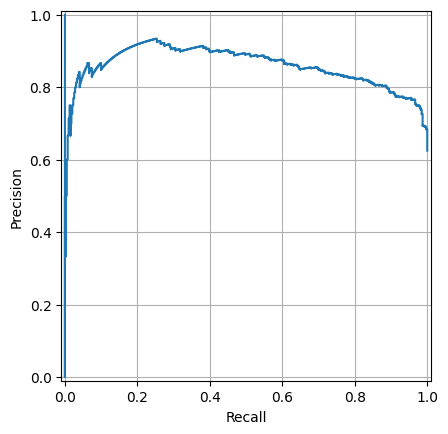

In [47]:

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()